# Flopy Tutorial: Loading and modifying a Simple MODFLOW Model

In the previous tutorial, we created a simple MODFLOW-2005 model using FloPy. In this tutorial, we will explore how to load in the model input files that we created in the previous tutorial, and then modify some of the model inputs to see how the model responds to our changes.

First, let's complete our standard imports and set up the model name and path to the MODFLOW executable. We then simply use the `flopy.modflow.Modflow.load()` function to load in the model from the existing input files.

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import os

modelname = "simple_modflow_model"
original_ws = './simple_model'
modflow_path = '../../../modflow/mf2005'
m = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', exe_name=modflow_path)
print(m)

MODFLOW 1 layer(s) 10 row(s) 10 column(s) 1 stress period(s)


# 1. Interacting with the loaded model

With our model in hand we now wish to modify some pieces of it. Let's start by examining the model structure and some of the key packages that we will want to modify.

In [2]:
# List all packages in the model
print("Available packages:")
print(m.get_package_list())
print("\n" + "="*60)

# Get model dimensions
print(f"\nModel dimensions:")
print(f"  Layers: {m.nlay}")
print(f"  Rows: {m.nrow}")
print(f"  Columns: {m.ncol}")
print(f"  Stress periods: {m.nper}")
print("\n" + "="*60)

# Access specific packages
dis = m.dis  # Discretization package
bas = m.bas6  # Basic package
lpf = m.lpf  # Layer Property Flow package
wel = m.wel  # Well package
rch = m.rch  # Recharge package

print(f"\nKey package information:")
print(f"  DIS - Discretization")
print(f"  BAS6 - Basic Package")
print(f"  LPF - Layer Property Flow")
print(f"  WEL - Well Package")
print(f"  RCH - Recharge Package")

Available packages:
['DIS', 'BAS6', 'LPF', 'OC', 'PCG']


Model dimensions:
  Layers: 1
  Rows: 10
  Columns: 10
  Stress periods: 1


Key package information:
  DIS - Discretization
  BAS6 - Basic Package
  LPF - Layer Property Flow
  WEL - Well Package
  RCH - Recharge Package


## 2. Inspecting Hydraulic Properties

Now let's look at the hydraulic conductivity. We can access the LPF package and print out the hydraulic conductivity array.

In [3]:
# Access hydraulic conductivity
hk = lpf.hk.array  # Horizontal hydraulic conductivity
vka = lpf.vka.array  # Vertical hydraulic conductivity (or anisotropy ratio)
ss = lpf.ss.array  # Specific storage
sy = lpf.sy.array  # Specific yield

print(f"Hydraulic conductivity (K) statistics:")
print(f"  Value: {np.mean(hk):.2f} m/d")
print(f"  Shape: {hk.shape}")
print(f"\nSpecific yield (Sy) statistics:")
print(f"  Mean: {np.mean(sy):.4f}")
print(f"  Shape: {sy.shape}")


Hydraulic conductivity (K) statistics:
  Value: 5.00 m/d
  Shape: (1, 10, 10)

Specific yield (Sy) statistics:
  Mean: 0.0000
  Shape: (1, 10, 10)


## 3. Creating a Modified Model

Now let's create a modified version of the model with different hydraulic properties. We'll create this in a **separate directory** to avoid overwriting the original model outputs.

The key principle: **Always write modified models to separate directories to preserve original results!**

In [ ]:
m_original = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', 
                                        exe_name=modflow_path, check=False)
    
# Set up the modified model in a SEPARATE directory
new_modelname = 'modified_model'
model_ws_modified = './modified_model'
os.makedirs(model_ws_modified, exist_ok=True)
m_mod = flopy.modflow.Modflow(modelname=new_modelname, 
                              exe_name=modflow_path,
                              model_ws=model_ws_modified)

# Copy discretization from original
dis = flopy.modflow.ModflowDis(m_mod, 
                                nlay=m.nlay, 
                                nrow=m.nrow, 
                                ncol=m.ncol,
                                delr=m.dis.delr.array, 
                                delc=m.dis.delc.array,
                                top=m.dis.top.array, 
                                botm=m.dis.botm.array,
                                nper=m.nper,
                                perlen=m.dis.perlen.array,
                                nstp=m.dis.nstp.array,
                                steady=m.dis.steady.array)

# Copy basic package
bas = flopy.modflow.ModflowBas(m_mod, 
                                ibound=m.bas6.ibound.array, 
                                strt=m.bas6.strt.array)

# Modify hydraulic conductivity to introduce heterogeneity
np.random.seed(42)  # For reproducibility
new_hk = np.random.normal(loc=10.0, scale=2.0, size=hk.shape)  # Mean 10 m/d, std 2 m/d
new_hk[new_hk < 0.1] = 0.1  # Ensure minimum K value

# Create LPF package with modified K
lpf_mod = flopy.modflow.ModflowLpf(m_mod, hk=new_hk, vka=1.0, sy=0.2, ss=1e-5, laytyp=1)

# Add solver
pcg = flopy.modflow.ModflowPcg(m_mod)

# Add Output Control - CRITICAL for saving outputs!
spd = {(0, 0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(m_mod, stress_period_data=spd, compact=True)

print(f"\nModified hydraulic conductivity:")
print(f"  Original K: {np.mean(hk):.2f} m/d (uniform)")
print(f"  Modified K: {np.mean(new_hk):.2f} ± {np.std(new_hk):.2f} m/d (heterogeneous)")
print(f"  Range: {np.min(new_hk):.2f} - {np.max(new_hk):.2f} m/d")


Modified hydraulic conductivity:
  Original K: 5.00 m/d (uniform)
  Modified K: 9.79 ± 1.81 m/d (heterogeneous)
  Range: 4.76 - 13.70 m/d


In [5]:
# Write and run the modified model
m_mod.write_input()
success, buff = m_mod.run_model(silent=True)
hds_path = f'{model_ws_modified}/{new_modelname}.hds'

## 4. Comparing Model Results

Now let's compare the hydraulic heads between the original and modified models to see how the heterogeneous hydraulic conductivity affected the groundwater flow system.

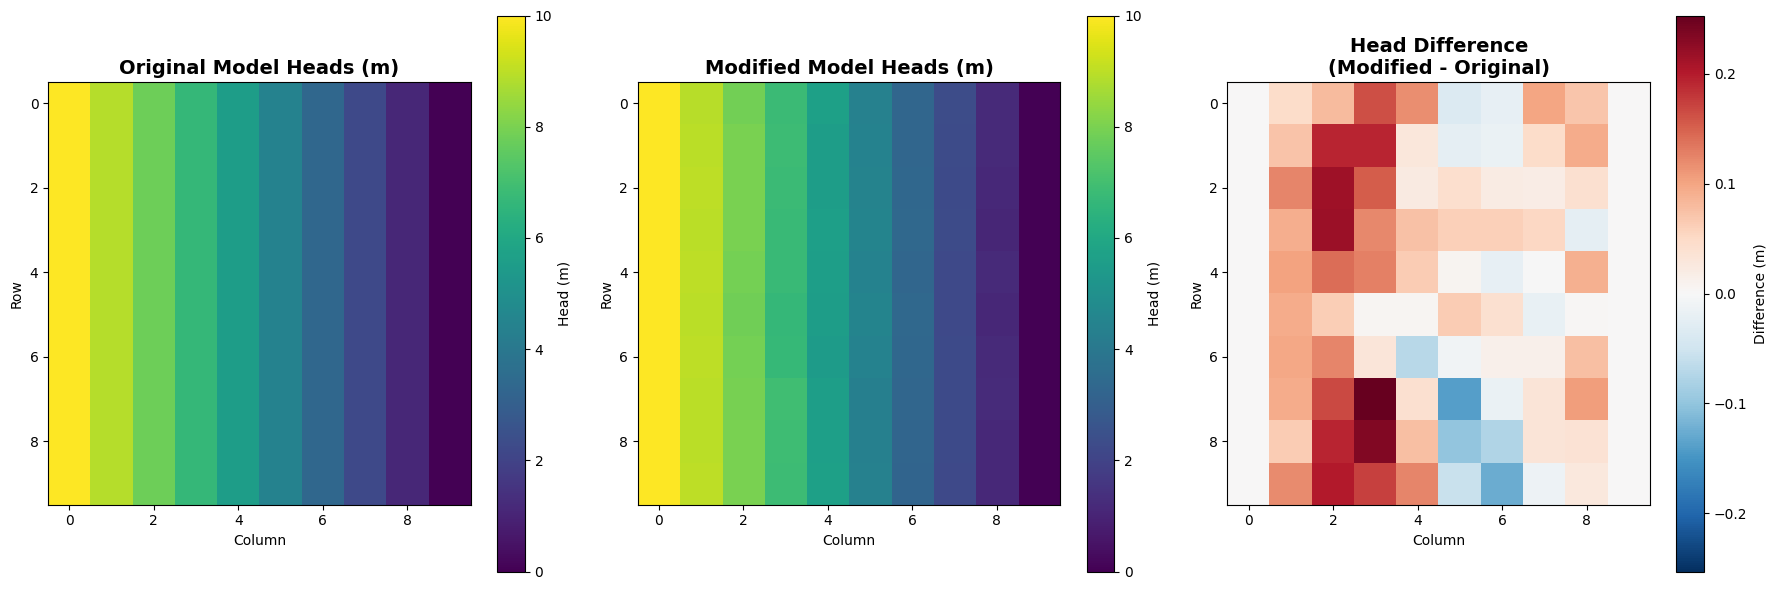

In [6]:
# Define file paths for both models
headfile_original = f'{original_ws}/{modelname}.hds'
headfile_modified = f'{model_ws_modified}/{new_modelname}.hds'

# Check if output files exist
if not os.path.exists(headfile_original):
    raise FileNotFoundError(f"Original model head file not found: {headfile_original}")

if not os.path.exists(headfile_modified):
    raise FileNotFoundError(f"Modified model head file not found: {headfile_modified}")

# Read heads from the original model
hds_original = flopy.utils.HeadFile(headfile_original)
head_original = hds_original.get_data()

# Read heads from the modified model
hds_modified = flopy.utils.HeadFile(headfile_modified)
head_modified = hds_modified.get_data()

# Calculate head difference and plot results
head_diff = head_modified - head_original
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = mp.cm.viridis

# Original heads
im1 = axes[0].imshow(head_original[0, :, :], cmap=cmap)
axes[0].set_title('Original Model Heads (m)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0], orientation='vertical', label='Head (m)')

# Modified heads
im2 = axes[1].imshow(head_modified[0, :, :], cmap=cmap)
axes[1].set_title('Modified Model Heads (m)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im2, ax=axes[1], orientation='vertical', label='Head (m)')

# Head difference
im3 = axes[2].imshow(head_diff[0, :, :], cmap='RdBu_r', 
                     vmin=-np.max(np.abs(head_diff)), 
                     vmax=np.max(np.abs(head_diff)))
axes[2].set_title('Head Difference\n(Modified - Original)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Column')
axes[2].set_ylabel('Row')
plt.colorbar(im3, ax=axes[2], orientation='vertical', label='Difference (m)')

plt.tight_layout()
plt.show()

## 5. Hands-On Exercise: Create Your Own Model Modification

Now it's your turn! Try creating a different model modification. The modified model above used a random heterogeneous K field. You can try something different!

**Ideas for your experiment:**

1. **Structured K zones**: Create high and low K zones (e.g., a low-K barrier)
2. **Spatial gradients**: Make K increase from west to east
3. **Add boundary conditions**: Add wells or constant head boundaries
4. **Modify layer geometry**: Change elevations or thicknesses

### Template for Your Experiment:

Follow the same pattern as above:
1. Create a separate directory for your experiment
2. Load the original model to get the structure
3. Create a new model instance
4. Copy and modify packages
5. Run and compare with the original

**Try it in the cell below!**

Running experiment: structured_barrier
Running experiment: spatial_gradient
Running experiment: pumping_well
Running experiment: geometry_change


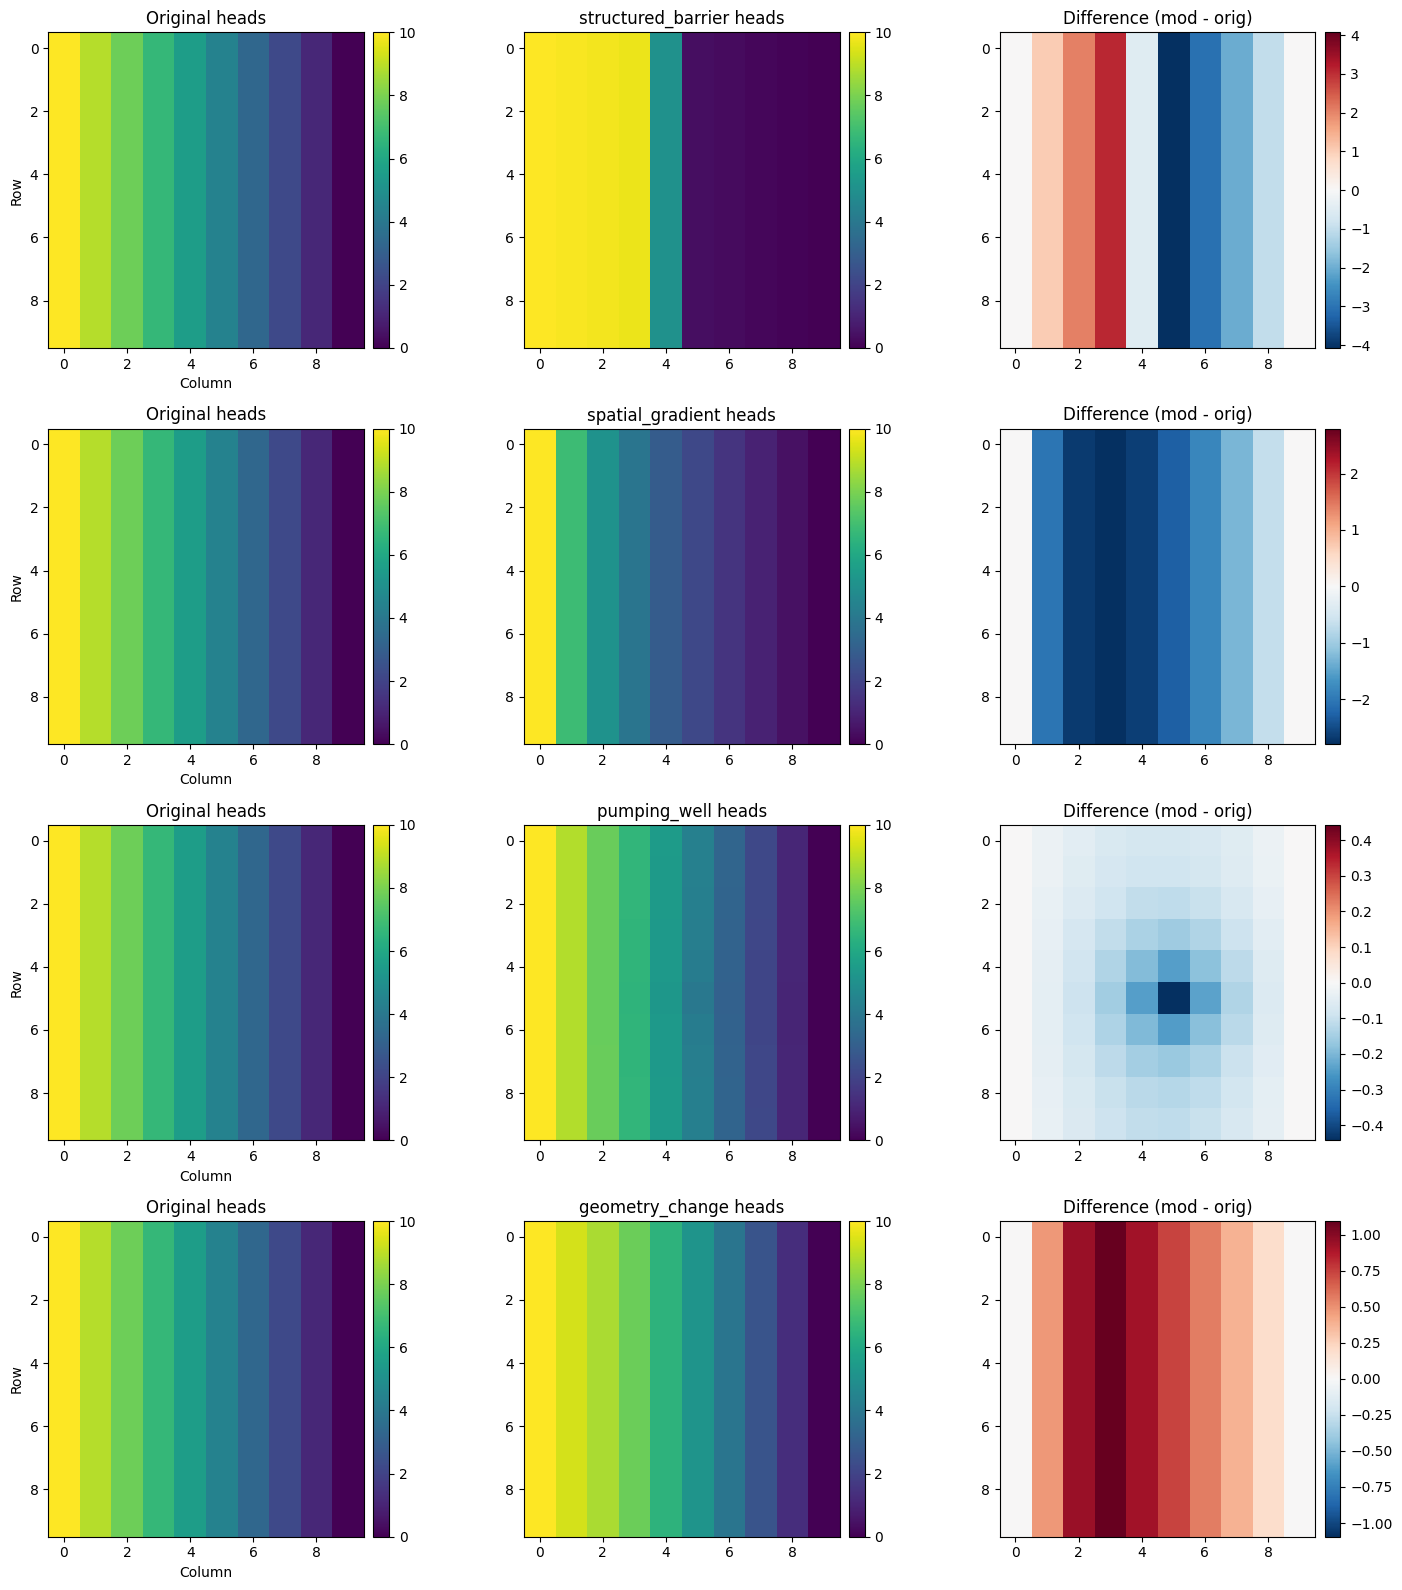

structured_barrier: diff mean=-0.4583, std=2.0929, min=-4.0741, max=3.0556
spatial_gradient: diff mean=-1.6223, std=1.0236, min=-2.7968, max=0.0000
pumping_well: diff mean=-0.0800, std=0.0714, min=-0.4429, max=0.0000
geometry_change: diff mean=0.5313, std=0.3734, min=0.0000, max=1.0951


In [9]:
# Experiment runner: structured zones, spatial gradient, add wells, modify geometry
# Uses existing notebook variables: original_ws, modelname, modflow_path, dis, hk, head_original

def make_modified_model(experiment_name, hk_mod, top_mod=None, botm_mod=None, wel_spd=None):
    ws = f'./exp_{experiment_name}'
    os.makedirs(ws, exist_ok=True)
    m_exp = flopy.modflow.Modflow(modelname=experiment_name, exe_name=modflow_path, model_ws=ws)

    # Discretization (use modified top/botm if provided)
    dis_top = top_mod if top_mod is not None else dis.top.array
    dis_botm = botm_mod if botm_mod is not None else dis.botm.array
    flopy.modflow.ModflowDis(m_exp,
                             nlay=dis.nlay, nrow=dis.nrow, ncol=dis.ncol,
                             delr=dis.delr.array, delc=dis.delc.array,
                             top=dis_top, botm=dis_botm,
                             nper=dis.nper,
                             perlen=dis.perlen.array, nstp=dis.nstp.array,
                             steady=dis.steady.array)

    # Basic package - copy ibound/starting heads from original basic package in workspace
    flopy.modflow.ModflowBas(m_exp, ibound=bas.ibound.array, strt=bas.strt.array)

    # LPF with modified hydraulic conductivity
    flopy.modflow.ModflowLpf(m_exp, hk=hk_mod, vka=1.0, sy=0.2, ss=1e-5, laytyp=1)

    # Optionally add well
    if wel_spd is not None:
        flopy.modflow.ModflowWel(m_exp, stress_period_data=wel_spd)

    # Solver and output control
    flopy.modflow.ModflowPcg(m_exp)
    spd_local = {(0, 0): ['save head', 'save budget']}
    flopy.modflow.ModflowOc(m_exp, stress_period_data=spd_local, compact=True)

    # Write and run
    m_exp.write_input()
    ok, buff = m_exp.run_model(silent=True)
    if not ok:
        print(f'Run failed for {experiment_name}; check model output in {ws}')
    return m_exp, ok, f'{ws}/{experiment_name}.hds'

# Prepare four experiments
nlay, nrow, ncol = dis.nlay, dis.nrow, dis.ncol

# 1) Structured K zones: low-K vertical barrier in middle columns
hk1 = hk.copy()
bar_cols = slice(int(ncol*0.45), int(ncol*0.55))  # middle ~1 column for this grid
hk1[:, :, bar_cols] = 0.05  # low-K barrier

# 2) Spatial gradient: increase K from west (col 0) to east (col ncol-1)
cols = np.arange(ncol, dtype=float)
grad = 2.0 + (18.0 * (cols / (ncol - 1)))  # from 2 to 20
hk2 = np.ones_like(hk) * grad[np.newaxis, np.newaxis, :]

# 3) Add boundary conditions: pumping well in center (keep original hk)
hk3 = hk.copy()
well_row = int(nrow / 2)
well_col = int(ncol / 2)
# wel stress_period_data uses zero-based layer,row,col, and flux (negative pumping)
wel_spd_3 = {0: [[0, well_row, well_col, -200.0]]}

# 4) Modify layer geometry: slope the top surface (west->east) and use slightly higher K in thicker side
top_base = dis.top.array.copy()
# slope top: increase elevation on western side
slope = np.linspace(0.5, -0.5, ncol)
top4 = top_base + slope[np.newaxis, :]
# reduce bottom (thicken western side)
botm_base = dis.botm.array.copy()
botm4 = botm_base.copy()
botm4[0] = botm_base[0] - (0.2 * (1 - (cols / (ncol - 1))))  # thicker on west
hk4 = hk.copy()
# increase K where thickness increased (west)
hk4[:, :, : int(ncol/3)] *= 2.0

# Run experiments
exps = {
    'structured_barrier': {'hk': hk1, 'top': None, 'botm': None, 'wel': None},
    'spatial_gradient':  {'hk': hk2, 'top': None, 'botm': None, 'wel': None},
    'pumping_well':      {'hk': hk3, 'top': None, 'botm': None, 'wel': wel_spd_3},
    'geometry_change':    {'hk': hk4, 'top': top4, 'botm': botm4, 'wel': None},
}

results = {}
for name, cfg in exps.items():
    print(f'Running experiment: {name}')
    m_exp, ok, hds_path = make_modified_model(name, cfg['hk'], top_mod=cfg['top'], botm_mod=cfg['botm'], wel_spd=cfg['wel'])
    if ok and os.path.exists(hds_path):
        hds = flopy.utils.HeadFile(hds_path)
        head = hds.get_data()  # shape (times, nrow, ncol) typically (1,nrow,ncol)
        results[name] = head
    else:
        results[name] = None

# Plot comparisons: for each experiment show original, modified, and difference
fig, axes = plt.subplots(len(exps), 3, figsize=(15, 4 * len(exps)))
cmap = mp.cm.viridis
for i, (name, head_mod) in enumerate(results.items()):
    ax_orig = axes[i, 0]
    ax_mod = axes[i, 1]
    ax_diff = axes[i, 2]

    ax_orig.imshow(head_original[0, :, :], cmap=cmap)
    ax_orig.set_title('Original heads')
    ax_orig.set_xlabel('Column'); ax_orig.set_ylabel('Row')

    if head_mod is None:
        ax_mod.text(0.5, 0.5, 'Run failed', ha='center', va='center')
        ax_mod.set_title(f'{name} (failed)')
        ax_diff.axis('off')
        continue

    ax_mod.imshow(head_mod[0, :, :], cmap=cmap)
    ax_mod.set_title(f'{name} heads')
    v = head_mod[0, :, :] - head_original[0, :, :]
    im = ax_diff.imshow(v, cmap='RdBu_r', vmin=-np.max(np.abs(v)), vmax=np.max(np.abs(v)))
    ax_diff.set_title('Difference (mod - orig)')

    # colorbars
    plt.colorbar(ax_orig.images[0], ax=ax_orig, orientation='vertical', fraction=0.046, pad=0.02)
    plt.colorbar(ax_mod.images[0], ax=ax_mod, orientation='vertical', fraction=0.046, pad=0.02)
    plt.colorbar(im, ax=ax_diff, orientation='vertical', fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()

# Print brief summary
for name, head_mod in results.items():
    if head_mod is None:
        print(f'{name}: failed or missing output')
    else:
        diff = (head_mod - head_original)[0]
        print(f'{name}: diff mean={np.mean(diff):.4f}, std={np.std(diff):.4f}, min={np.min(diff):.4f}, max={np.max(diff):.4f}')

In [7]:
m_original = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', 
                                        exe_name=modflow_path, check=False)
    
# Set up the modified model in a SEPARATE directory
new_modelname = 'modified_model'
model_ws_modified = './modified_model'
os.makedirs(model_ws_modified, exist_ok=True)
m_mod = flopy.modflow.Modflow(modelname=new_modelname, 
                              exe_name=modflow_path,
                              model_ws=model_ws_modified)

# Copy discretization from original
dis = flopy.modflow.ModflowDis(m_mod, 
                                nlay=m.nlay, 
                                nrow=m.nrow, 
                                ncol=m.ncol,
                                delr=m.dis.delr.array, 
                                delc=m.dis.delc.array,
                                top=m.dis.top.array, 
                                botm=m.dis.botm.array,
                                nper=m.nper,
                                perlen=m.dis.perlen.array,
                                nstp=m.dis.nstp.array,
                                steady=m.dis.steady.array)

# Copy basic package
bas = flopy.modflow.ModflowBas(m_mod, 
                                ibound=m.bas6.ibound.array, 
                                strt=m.bas6.strt.array)

# Modify hydraulic conductivity to introduce heterogeneity
np.random.seed(42)  # For reproducibility
new_hk = np.random.normal(loc=10.0, scale=2.0, size=hk.shape)  # Mean 10 m/d, std 2 m/d
new_hk[new_hk < 0.1] = 0.1  # Ensure minimum K value

# Create LPF package with modified K
lpf_mod = flopy.modflow.ModflowLpf(m_mod, hk=new_hk, vka=1.0, sy=0.2, ss=1e-5, laytyp=1)

# Add solver
pcg = flopy.modflow.ModflowPcg(m_mod)

# Add Output Control - CRITICAL for saving outputs!
spd = {(0, 0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(m_mod, stress_period_data=spd, compact=True)

print(f"\nModified hydraulic conductivity:")
print(f"  Original K: {np.mean(hk):.2f} m/d (uniform)")
print(f"  Modified K: {np.mean(new_hk):.2f} ± {np.std(new_hk):.2f} m/d (heterogeneous)")
print(f"  Range: {np.min(new_hk):.2f} - {np.max(new_hk):.2f} m/d")


Modified hydraulic conductivity:
  Original K: 5.00 m/d (uniform)
  Modified K: 9.79 ± 1.81 m/d (heterogeneous)
  Range: 4.76 - 13.70 m/d
